In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [3]:
df = pd.read_csv('data/merged_climate_iom_data.csv')

In [4]:
# Sorting by country and time to ensure proper filling
df.sort_values(by=["country_code", "year", "month"], inplace=True)

columns_to_fill_extended = [
    "AG.LND.FRST.K2", "AG.LND.PRCP.MM", "AG.LND.TOTL.K2", "AG.SRF.TOTL.K2",
    "EG.CFT.ACCS.RU.ZS", "EG.CFT.ACCS.UR.ZS", "EG.CFT.ACCS.ZS", "EG.EGY.PRIM.PP.KD", "EG.ELC.ACCS.ZS", "EG.FEC.RNEW.ZS",
    "EN.GHG.ALL.MT.CE.AR5", "EN.GHG.CH4.AG.MT.CE.AR5", "EN.GHG.CH4.BU.MT.CE.AR5", "EN.GHG.CH4.FE.MT.CE.AR5",
    "EN.GHG.CH4.IC.MT.CE.AR5", "EN.GHG.CH4.MT.CE.AR5", "EN.GHG.CH4.PI.MT.CE.AR5", "EN.GHG.CH4.TR.MT.CE.AR5",
    "EN.GHG.CH4.WA.MT.CE.AR5", "EN.GHG.CO2.BU.MT.CE.AR5", "EN.GHG.CO2.IC.MT.CE.AR5", "EN.GHG.CO2.IP.MT.CE.AR5",
    "EN.GHG.CO2.LU.MT.CE.AR5", "EN.GHG.CO2.MT.CE.AR5", "EN.GHG.CO2.PI.MT.CE.AR5", "EN.GHG.CO2.TR.MT.CE.AR5",
    "EN.GHG.FGAS.IP.MT.CE.AR5", "EN.GHG.N2O.AG.MT.CE.AR5", "EN.GHG.N2O.BU.MT.CE.AR5", "EN.GHG.N2O.FE.MT.CE.AR5",
    "EN.GHG.N2O.IC.MT.CE.AR5", "EN.GHG.N2O.IP.MT.CE.AR5", "EN.GHG.N2O.MT.CE.AR5", "EN.GHG.N2O.PI.MT.CE.AR5",
    "EN.GHG.N2O.TR.MT.CE.AR5", "EN.GHG.N2O.WA.MT.CE.AR5", "ER.FSH.AQUA.MT", "ER.FSH.CAPT.MT", "ER.FSH.PROD.MT",
    "ER.H2O.FWTL.K3", "ER.H2O.INTR.K3", "SP.POP.TOTL"
]

columns_to_fill_extended = [col.lower() for col in columns_to_fill_extended]

# Filtering columns that exist in the dataset
existing_columns = [col for col in columns_to_fill_extended if col in df.columns]

df[existing_columns] = df.groupby("country_code")[existing_columns].transform(lambda x: x.ffill().bfill())

In [5]:
df['total_idp_over_pop'] = (df['internally_displaced_persons'] / df['sp.pop.totl'])*100
df['total_affected_over_pop'] = (df['total_affected'] / df['sp.pop.totl'])*100

In [6]:
weird_values = df[df['total_idp_over_pop'] > 100]

In [7]:
len(weird_values)

8

In [8]:
weird_values[['year','country_name', 'sp.pop.totl','internally_displaced_persons',  'total_idp_over_pop', 'total_affected_over_pop']].describe()

,year,sp.pop.totl,internally_displaced_persons,total_idp_over_pop,total_affected_over_pop
count,8.000000,8.000000e+00,8.000000e+00,8.000000,3.000000
mean,2022.250000,3.535141e+07,4.878471e+07,129.245549,49.949904
std,1.035098,2.027603e+07,3.285272e+07,29.424648,36.602761
min,2021.000000,1.086578e+07,1.114828e+07,102.599951,7.684676
25%,2021.000000,1.086578e+07,1.205802e+07,110.972392,39.383597
50%,2023.000000,5.004279e+07,5.963956e+07,119.177121,71.082518
75%,2023.000000,5.004279e+07,6.685620e+07,133.598064,71.082518
max,2023.000000,5.004279e+07,9.545158e+07,190.739913,71.082518


In [9]:
# Removing odd values, where we have more than 100% of the population displaced
df = df[df['total_idp_over_pop'] < 100]

In [19]:
df = df[df['country_name'].isin(['Sudan', 'South Sudan'])]

In [22]:
# Train a OLS linear regression model to predict IDP

env_factors = [
'ag.lnd.frst.k2', 'ag.lnd.prcp.mm',
       'ag.lnd.totl.k2', 'ag.srf.totl.k2', 'eg.cft.accs.ru.zs',
       'eg.cft.accs.ur.zs', 'eg.cft.accs.zs', 'eg.egy.prim.pp.kd',
       'eg.elc.accs.zs', 'eg.fec.rnew.zs', 'en.ghg.all.mt.ce.ar5',
       'en.ghg.ch4.ag.mt.ce.ar5', 'en.ghg.ch4.bu.mt.ce.ar5',
       'en.ghg.ch4.fe.mt.ce.ar5', 'en.ghg.ch4.ic.mt.ce.ar5',
       'en.ghg.ch4.mt.ce.ar5', 'en.ghg.ch4.pi.mt.ce.ar5',
       'en.ghg.ch4.tr.mt.ce.ar5', 'en.ghg.ch4.wa.mt.ce.ar5',
       'en.ghg.co2.bu.mt.ce.ar5', 'en.ghg.co2.ic.mt.ce.ar5',
       'en.ghg.co2.ip.mt.ce.ar5', 'en.ghg.co2.lu.mt.ce.ar5',
       'en.ghg.co2.mt.ce.ar5', 'en.ghg.co2.pi.mt.ce.ar5',
       'en.ghg.co2.tr.mt.ce.ar5', 'en.ghg.fgas.ip.mt.ce.ar5',
       'en.ghg.n2o.ag.mt.ce.ar5', 'en.ghg.n2o.bu.mt.ce.ar5',
       'en.ghg.n2o.fe.mt.ce.ar5', 'en.ghg.n2o.ic.mt.ce.ar5',
       'en.ghg.n2o.ip.mt.ce.ar5', 'en.ghg.n2o.mt.ce.ar5',
       'en.ghg.n2o.pi.mt.ce.ar5', 'en.ghg.n2o.tr.mt.ce.ar5',
       'en.ghg.n2o.wa.mt.ce.ar5', 'er.fsh.aqua.mt', 'er.fsh.capt.mt',
       'er.fsh.prod.mt', 'er.h2o.fwtl.k3', 'er.h2o.intr.k3', 'sp.pop.totl',
       'cpi_value', 'total_affected']

#impute mean to nas in env_factors

for col in env_factors:
       if col == 'total_affected':
              df[col].fillna(0, inplace=True)
       else:
              df[col].fillna(df[col].mean(), inplace=True)

# Drop rows with missing values in the selected columns
df_clean = df[["internally_displaced_persons"] + env_factors].dropna()

# Define independent (X) and dependent (y) variables
X = df_clean[env_factors]  # Environmental factors
y = df_clean["internally_displaced_persons"]  # Displacement

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6484\3808346310.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6484\3808346310.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

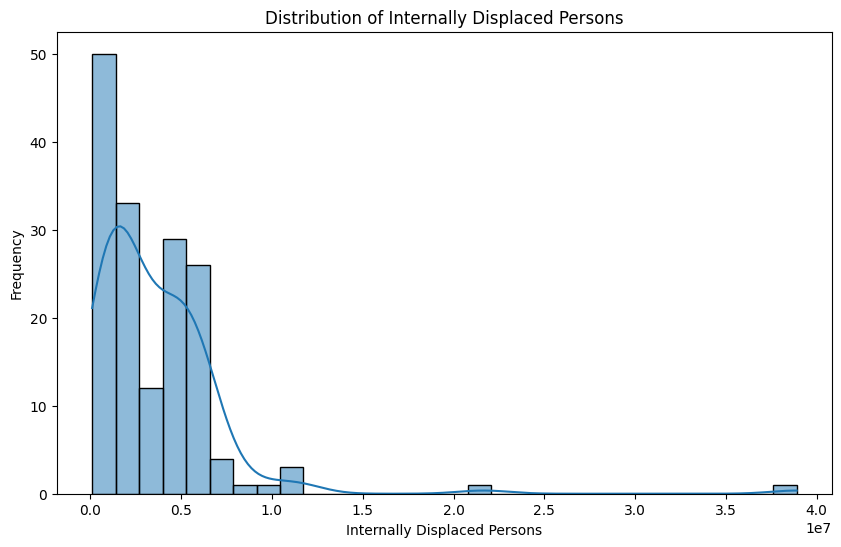

In [23]:
# distribution plot of tartget variable y
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Internally Displaced Persons')
plt.xlabel('Internally Displaced Persons')
plt.ylabel('Frequency')
plt.show()

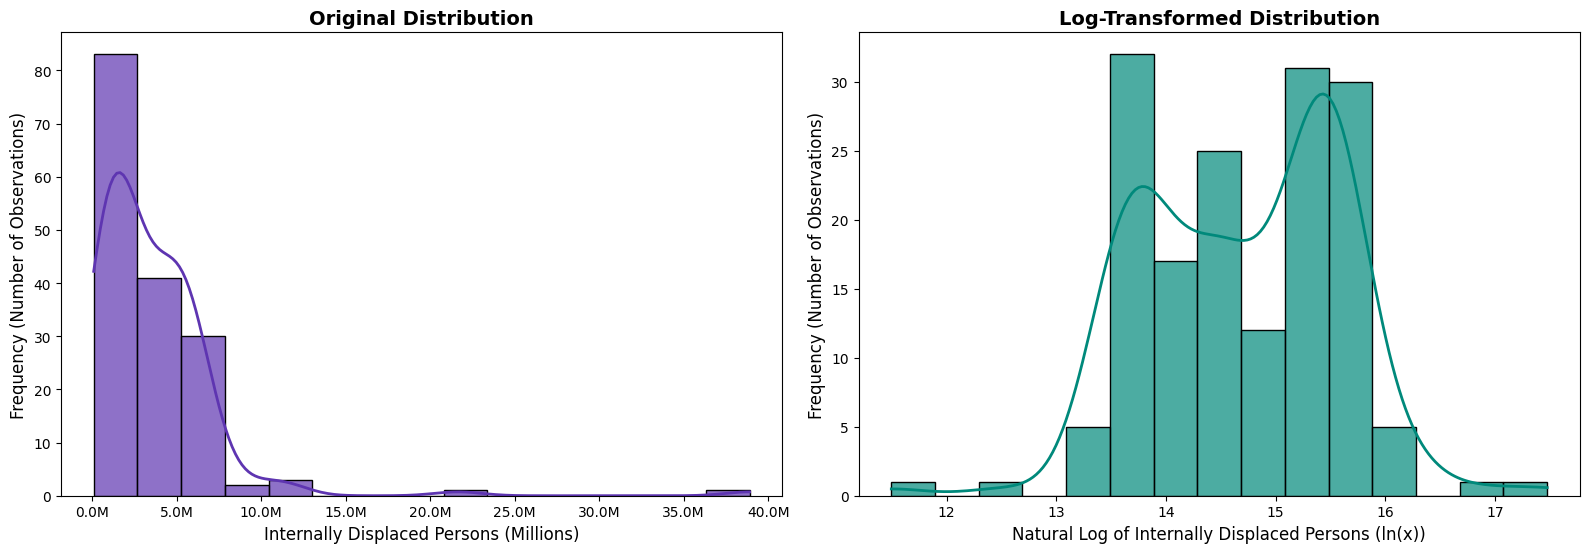

In [24]:
# Import libraries if not already imported
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot - Original distribution
sns.histplot(
    df['internally_displaced_persons'],
    bins=15,
    kde=True,
    color='#5e35b1',
    line_kws={'linewidth': 2, 'color': '#283593'},
    alpha=0.7,
    ax=ax1
)

# Improve original plot formatting
ax1.set_title('Original Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Internally Displaced Persons (Millions)', fontsize=12)
ax1.set_ylabel('Frequency (Number of Observations)', fontsize=12)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Second subplot - Log-transformed distribution
log_data = np.log1p(df['internally_displaced_persons'])  # Using log1p to handle zeros
sns.histplot(
    log_data,
    bins=15,
    kde=True,
    color='#00897b',
    line_kws={'linewidth': 2, 'color': '#00695c'},
    alpha=0.7,
    ax=ax2
)

ax2.set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Natural Log of Internally Displaced Persons (ln(x))', fontsize=12)
ax2.set_ylabel('Frequency (Number of Observations)', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

#### OLS Regression

In [25]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model on the training set
model_train = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model_train.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(2714840.7632445507, -0.2833556753466546)

#### Random Forest Model

In [27]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df_clean.drop(columns=["internally_displaced_persons"]), drop_first=True)

# Fill missing values with the median
#df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))
#y_filled = df["internally_displaced_persons"]

# Split into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_encoded[env_factors], y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

mae_rf, r2_rf

(740541.3067294373, 0.8758708730938629)

In [28]:
# Get coefficients for the linear regression model

coefficients = model_train.params
coefficients = coefficients[1:]  # Exclude the intercept

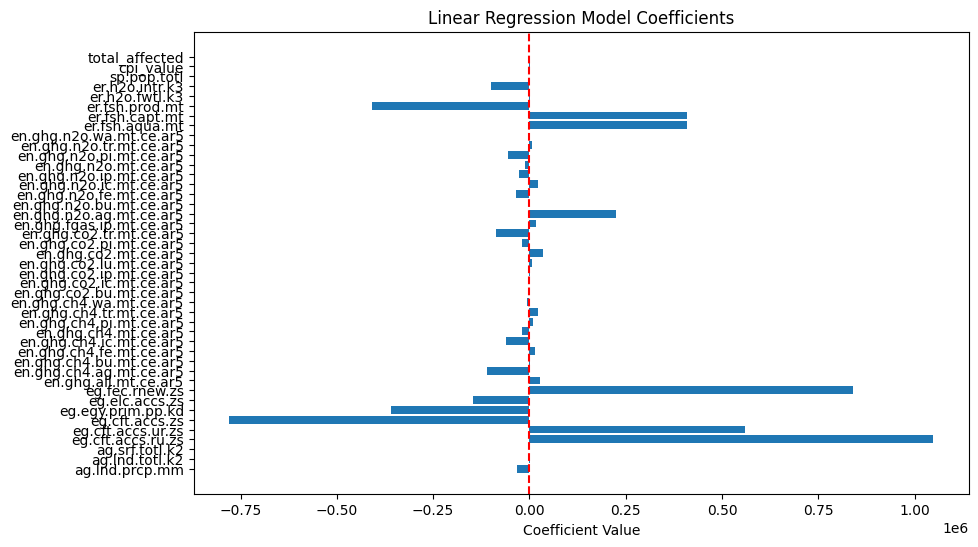

In [31]:
# plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients.index, coefficients.values)
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Model Coefficients')
plt.axvline(0, color='red', linestyle='--')
plt.show()

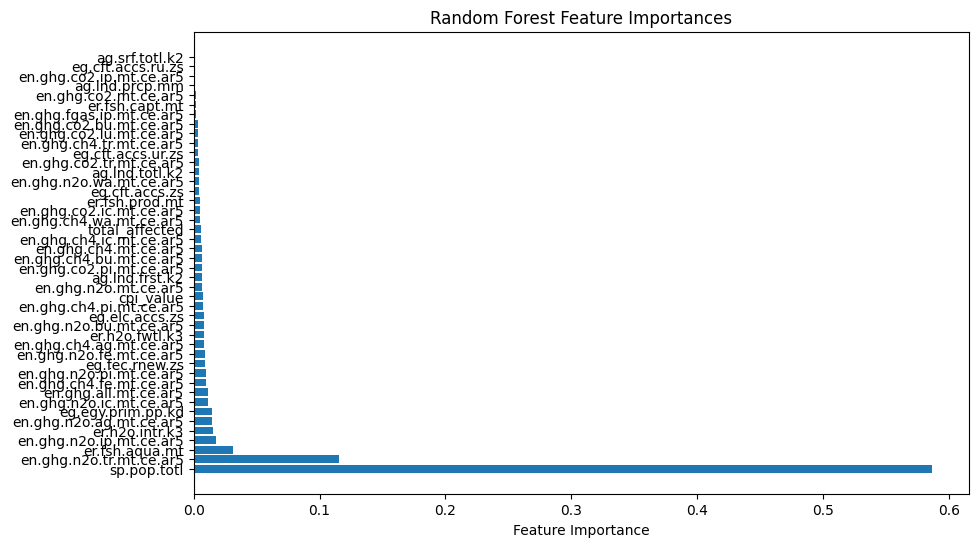

In [32]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = df_encoded[env_factors].columns
indices = np.argsort(importances)[::-1]

#plot feature importances

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.axvline(0, color='red', linestyle='--')
plt.show()
